Run all the cells in order

In [ ]:
#mount the google driver
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
#import dependencies
from IPython.display import display, Javascript,HTML, JSON
from google.colab.output import eval_js
from base64 import b64decode, b64encode
from PIL import Image
import io
import numpy as np
import cv2 
import os
import IPython
import uuid
from google.colab import output
from IPython.display import Image as Im
import time, sys
from IPython.display import clear_output

we need to get the haarcascade file for using use Casscasde Classifier in the fact detect part

In [ ]:
!wget https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_frontalface_alt.xml -q

In [ ]:
#save the cascade file, we'll use it later
cascade_fn = "haarcascade_frontalface_alt.xml"
cascade = cv2.CascadeClassifier(cv2.samples.findFile(cascade_fn))

In [ ]:
#define functions
#use array to represent the image
def byte2image(byte):
  jpeg = b64decode(byte.split(',')[1])
  im = Image.open(io.BytesIO(jpeg))
  return np.array(im)

# encode from array to b64 code
def image2byte(image):
  image = Image.fromarray(image)
  buffer = io.BytesIO()
  image.save(buffer, 'jpeg')
  buffer.seek(0)
  x = b64encode(buffer.read()).decode('utf-8')
  return x

#this function draws the square
def draw_rects(img, rect, color):
    x1, y1, x2, y2 = rect
    cv2.rectangle(img, (x1, y1), (x2, y2), color, 8)

#this function detect the face in image and return the position
def detect(img, cascade):
  #Apply the AdaBoost classifier 
    rects = cascade.detectMultiScale(img, scaleFactor=1.3, minNeighbors=4, minSize=(30, 30),
                                     flags=cv2.CASCADE_SCALE_IMAGE)
    if len(rects) == 0:
        return []
   #If faces are found, it returns the positions of detected faces as Rect(x,y,w,h),we then transfer it to (x,y,x+w,y+h)
    rects[:,2:] += rects[:,:2]
    return rects



This function is for showing video and taking photo

In [ ]:
def VideoCapture():
  js = Javascript('''
    async function create(){
      div = document.createElement('div');
      document.body.appendChild(div);

      video = document.createElement('video');
      video.setAttribute('playsinline', '');
      video.style.display = "none";

      div.appendChild(video);

      stream = await navigator.mediaDevices.getUserMedia({video: {facingMode: "environment"}});
      video.srcObject = stream;

      await video.play();

      canvas =  document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);

      div_out = document.createElement('div');
      document.body.appendChild(div_out);
      
      img224 = document.createElement('img');
      img224.id = "finalImage224";
      div_out.appendChild(img224);

      img64 = document.createElement('img');
      img64.id = "finalImage64";
      div_out.appendChild(img64);

      transfer = document.createElement('div');
      transfer.id = "transfer";
      transfer.style.color = "none";
      document.body.appendChild(transfer);

      //window.arr64 = [];
      //window.arr224 = [];

    }

    async function capture(){
        return await new Promise(function(resolve, reject){
            pendingResolve = resolve;
            canvas.getContext('2d').drawImage(video, 0, 0);
            result = canvas.toDataURL('image/jpeg', 0.8);
            pendingResolve(result);
        })
    }

    function showimg(imgsourceb64){
        img64.src = "data:image/jpg;base64," + imgsourceb64;
    
    }

  ''')
  display(js)


In [ ]:
#this button click function is borrowed from Mr. Seyed Farzam

def ClickTracker():
  js = Javascript('''

    // Add a button under the images for clicking and save the image
    async function JSSaveImage() {
      button = document.createElement('button');
      button.setAttribute('content', 'Click to Save Image');
      button.setAttribute('onclick', 'savejs()');
      button.innerHTML = 'Click to Save Image';
      

      input = document.createElement('input')
      input.id = "inputLetter"

      document.body.appendChild(input);
      document.body.appendChild(button);
    } 
 
    function  savejs() {
      document.getElementById("transfer").innerHTML = "photo is saved";
    }

    // in each iteration the python code execute this function and based on the message save the images or not
    async function  checkForSave() {
      decide = document.getElementById("transfer").innerHTML;
      document.getElementById("transfer").innerHTML = "waiting";
      if( decide == "photo is saved") {
          return true;
      }
      else {
          return false;
      }
    }

    async function getLetter() {
       decide = document.getElementById("inputLetter").value;
       return await decide
    }

    ''')
  display(js)

Finding the best HSV masks

 the HSV mask should be different in different enviroment, so it's better to find the best combination each time before saving images

 The following HSV related function come from Seyed Farzam

In [ ]:
def HSVJSPANEL():
  js2 = Javascript('''
    // Add a button under the images for clicking and save the image
    async function PanelHSV() {  
      heading1 = MakeHeader("from", 'h6');
      h0 = Makeinput("h0",0);
      s0 = Makeinput("s0",0);
      v0 = Makeinput("v0",0);
      document.body.appendChild(document.createElement('br'));
      document.body.appendChild(document.createElement('br'));
      heading2 = MakeHeader("to", 'h6');
      h1 = Makeinput("h1",255);
      s1 = Makeinput("s1",255);
      v1 = Makeinput("v1",255);
    }
    function Makeinput(id, value){
      input = document.createElement('input');
      input.setAttribute('type', 'number');
      input.setAttribute('min', '0');
      input.setAttribute('max', '255');
      input.setAttribute('value', value);
      input.id = id;
      document.body.appendChild(input);
    }
    function MakeHeader(text, type) {
      heading = document.createElement(type);
      heading.innerHTML = text;
      document.body.appendChild(heading);
    }
    async function GetResult() {
       var result = {
         "h0" : document.getElementById("h0").value,
         "s0" : document.getElementById("s0").value,
         "v0" : document.getElementById("v0").value,
         "h1" : document.getElementById("h1").value,
         "s1" : document.getElementById("s1").value,
         "v1" : document.getElementById("v1").value
       }
       return await result
    }
    ''')
  display(js2)

In [ ]:
#run this one and modify to get the best numbers for masks
def HSVTunner():
  HSVJSPANEL()
  eval_js('PanelHSV()')
  VideoCapture()
  eval_js('create()')
  prob=[]

  while True:
      byte = eval_js('capture()')
      im = byte2image(byte)
      dichsv = eval_js('GetResult()')
      fromhsv = np.array((float(dichsv['h0']), float(dichsv['s0']), float(dichsv['v0'])))
      tohsv = np.array((float(dichsv['h1']), float(dichsv['s1']), float(dichsv['v1'])))

      hsv = cv2.cvtColor(im, cv2.COLOR_BGR2HSV)
      mask=cv2.inRange(hsv,fromhsv,tohsv)
      hist = cv2.calcHist( [hsv], [0], mask, [16], [0, 180] )
      cv2.normalize(hist, hist, 0, 255, cv2.NORM_MINMAX)
      hist = hist.reshape(-1)
      prob = cv2.calcBackProject([hsv], [0], hist, [0, 180], 1)
      prob &= mask
      #prob = camshiftTracker.checkProbability(im, fromhsv, tohsv)
      eval_js('showimg("{}")'.format(image2byte(prob)))
HSVTunner()

MessageError: ignored

Following three cells are just for creating and changing directory in Google Drive

In [ ]:
cd drive/'My Drive'

/content/drive/My Drive


In [ ]:
#create a folder
os.mkdir('yourhand')

In [ ]:
#change directory to this folder
cd 'yourhand'

/content/drive/My Drive/yourhand


#Create dataset
Next step is taking photo, detect and save.

Input the letter you want to save, then click button will save two probability images, 16* 16 and 224* 224

Set the starting number of the file name here

In [ ]:
# this function for creating our dataset
def getphotos():
  # run JS function for capture the video stream
  VideoCapture()
  eval_js('create()')

  #run JS script for click and save the image
  ClickTracker()
  eval_js('JSSaveImage()')

  show_backproj=False

  #Initialize lists
  rects=[]
  track_window_hand=()
  prob16=[]
  prob224=[]
  ############set the starting number of the file name #######################
  num=0

  while True:
    byte = eval_js('capture()')
    im = byte2image(byte)

    vis = im.copy()
    imcopy=im.copy()

    # load input image in hsv mode:
    hsv = cv2.cvtColor(im, cv2.COLOR_BGR2HSV)
    mask = cv2.inRange(hsv, np.array((25., 30., 30.)), np.array((180., 180., 204.)))

    new_track_window=None

    # check if there's face been detected

    if len(rects):
  #locate the position of face and define an area
        for rect in rects:
          x11,y11,x22,y22=rect
          #set the margin as 20% of the height plus 30 pixels
          pad=int(0.2*(y22-y11))+30
          x1=x11-pad 
          # the space should lie inside the video screen
          if x1 <0 :
            x1=0

          y1=y11-pad
          if y1 <0:
            y1=0

          x2=x22+pad
          if x2>im.shape[1]:
            x2=im.shape[1]

          y2=y22+pad
          if y2>im.shape[0]:
            y2=im.shape[0]

          #back projection records how well the pixels fit the pixels of a histogram 
          prob = cv2.calcBackProject([hsv], [0], hist, [0, 180], 1)
          prob &= mask
          term_crit = ( cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 1 )

          track_box, track_window = cv2.CamShift(prob[y1:y2,x1:x2], track_window, term_crit)

          if track_window is not None:

            xx,yy,ww,hh=track_window

            rect=[xx+x1,yy+y1,xx++x1+ww,yy+y1+hh]

          #if can't find the face in that area we search for the whole screen
          else:

              xr1,yr1,xr2,yr2=rect
              track_window=(xr1+x1,yr1+y2,xr2-xr1,yr2-yr1)
              track_box, track_window = cv2.CamShift(prob, track_window, term_crit)

              xx,yy,ww,hh=track_window
              rect=[xx,yy,xx+ww,yy+hh]
            
        # set the probability of face as zero 
          xp1,yp1,xp2,yp2=rect
          prob2=prob
          prob2[yp1:yp2,xp1:xp2]=0

          if show_backproj is True:  
            imcopy[:] = prob2[...,np.newaxis]
      
          #use the histgram we already get to find the hand

          track_box_hand, track_window_hand = cv2.CamShift(prob2, track_window, term_crit)
          xx,yy,ww,hh=track_window_hand
          rect_hand=[xx,yy,xx+ww,yy+hh]

          draw_rects(imcopy, rect_hand, (0, 255, 0))   

          #the position of the hand 

          hand_prob=prob2[yy:yy+hh,xx:xx+ww]

          #prob16 is for storing the probability of 16*16 image
          #prob224 is for storing the probability of 224*224 image

          prob16=cv2.resize(hand_prob, (16,16), interpolation = cv2.INTER_AREA)
          prob224=cv2.resize(hand_prob, (224,224), interpolation = cv2.INTER_AREA)

                                                                          
  #before we track the histogram, we first need to detect the face and get the position

    else:

    
          gray = cv2.cvtColor(vis, cv2.COLOR_RGB2GRAY)

          #use Cascade classifier to detect the face

          rects = detect(gray, cascade)

          if len(rects)>0:

            for rect in rects:
              x11,y11,x22,y22=rect

            track_window=(x11,y11,x22-x11,y22-y11)
            hsv_roi = hsv[y11:y22,x11:x22]
            mask_roi = mask[y11:y22,x11:x22]

            #calculate the histogram
            hist = cv2.calcHist( [hsv_roi], [0], mask_roi, [16], [0, 180] )
            cv2.normalize(hist, hist, 0, 255, cv2.NORM_MINMAX)
            hist = hist.reshape(-1)
            vis_roi =vis[y11:y22,x11:x22]
            cv2.bitwise_not(vis_roi, vis_roi)
            vis[mask == 0] = 0

            #set the margin as 20% of the height plus 30 pixels
            pad=int(0.2*(y22-y11))+30
            x1=x11-pad 
            # make sure the space lie inside the video screen
            if x1 <0 :
              x1=0

            y1=y11-pad
            if y1 <0:
              y1=0

            xx,yy,ww,hh=track_window
            track_window=(xx-x1,yy-y1,ww,hh)

            #for subrects in rects:
              #draw_rects(imcopy, subrects, (0, 255, 0))
          else:
            print("no face detected")
      
    eval_js('showimg("{}")'.format(image2byte(imcopy)))
    shouldISave = eval_js('checkForSave()')
    
    if shouldISave:
          letter = eval_js('getLetter()')   
          #count the number of images 
          num=num+1
          #save two files for each images

          filename16=letter+"_"+str(num)+"_"+str(16)+".jpg"
          filename224=letter+"_"+str(num)+"_"+str(224)+".jpg"
          im1 = Image.fromarray(prob16)
          im1.save(filename16)
          im2 = Image.fromarray(prob224)
          im2.save(filename224)     



In [ ]:
#call the function to start building our dataset
getphotos()

MessageError: ignored

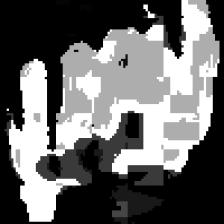

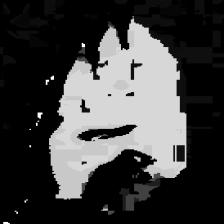

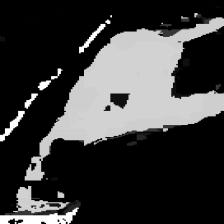

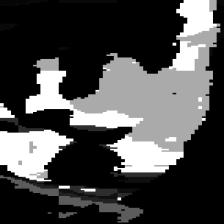

In [ ]:
#display some images
display(Im('A_100_224.jpg'))
display(Im('B_100_224.jpg'))
display(Im('C_100_224.jpg'))
display(Im('D_90_224.jpg'))

In [ ]:
#save all the 16*16 images to a txt file
listoffiles=os.listdir()
for file in listoffiles:
  if file.endswith("16.jpg"):
    aletter=file[0]
    imarrayy = np.array(Image.open(file))
    imarrayyf= np.append(np.array([aletter]),imarrayy)

    with open('dataset.txt', 'a') as f:
      np.savetxt(f, np.column_stack(imarrayyf),delimiter=",", fmt='%s')

In [ ]:
#shuffle the lines
import random
lines = open('dataset.txt').readlines()
random.shuffle(lines)
open('dataset.txt', 'w').writelines(lines)

In [ ]:
#create two arrays for samples and letters
def load_dataset(dataset_file_path):
    a = np.loadtxt(dataset_file_path, delimiter=',', converters={ 0 : lambda ch : ord(ch)-ord('A') })
    samples, letters = a[:,1:], a[:,0]
    return samples, letters

samples, letters= load_dataset("dataset.txt")

#MLP

Next we will train the model, the dataset I used is letter A,B,C,D. Each letter has around 200 images.

In [ ]:
#split the dataset
num_classes = 4
train_ratio = 0.7
n_train_samples = int(len(samples) * train_ratio)
x_train, y_train = samples[:n_train_samples], letters[:n_train_samples]
x_val, y_val = samples[n_train_samples:], letters[n_train_samples:]

x_train = x_train.astype('float32')
x_val = x_val.astype('float32')
x_train /= 255
x_val /= 255
print(x_train.shape[0], 'train samples')
print(x_val.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_val = keras.utils.to_categorical(y_val, num_classes)

509 train samples
219 test samples


In [ ]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout

Using TensorFlow backend.


In [ ]:
#clear the previouss model built before building a new training model
keras.backend.clear_session()

For the model, I modify the number of neurals to 200, and delete the two drop layers. The accuracy i got is 0.968

Following shows the 6 different combinations I have tried and the respect accuracy:





> layer 1: Dense 100   dropout 2: 0.2   layer 3 : Dense 100   Dropout 4:0.2    Accuracy: 0.91

> layer 1: Dense 200   dropout 2: 0.2   layer 3 : Dense 100  Dropout 4:0.1    Accuracy: 0.940

> layer 1: Dense 100    layer 2 : Dense 100   Dropout 3: 0.2    Accuracy: 0.958

> layer 1: Dense 100    layer 2 : Dense 100     Accuracy: 0.963

> layer 1: Dense 200    layer 2 : Dense 100     Accuracy: 0.968

> layer 1: Dense 300    layer 2 : Dense 100     Accuracy: 0.958

In [ ]:
#build and train the model, my dataset only has 4 letters so I set class as 4
num_classes = 4
epochs = 20

model = Sequential()
model.add(Dense(300, activation='relu', input_shape=(256,)))
#model.add(Dropout(0.2))
model.add(Dense(100, activation='relu'))
#model.add(Dropout(0.2))
model.add(Dense(num_classes, activation='softmax'))

model.summary()

model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

history = model.fit(x_train, y_train,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(x_val, y_val))
score = model.evaluate(x_val, y_val, verbose=0)
print('Validation loss:', score[0])
print('Validation accuracy:', score[1])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 300)               77100     
_________________________________________________________________
dense_2 (Dense)              (None, 100)               30100     
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 404       
Total params: 107,604
Trainable params: 107,604
Non-trainable params: 0
_________________________________________________________________
Train on 509 samples, validate on 219 samples
Epoch 1/20
509/509 [==============================] - 0s 236us/step - loss: 0.9359 - accuracy: 0.6582 - val_loss: 0.5883 - val_accuracy: 0.8128
Epoch 2/20
509/509 [==============================] - 0s 89us/step - loss: 0.4859 - accuracy: 0.8310 - val_loss: 0.6234 - val_accuracy: 0.7763
Epoch 3/20
509/509 [=========================

In [ ]:
#save the model
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
model.save_weights("model_weights.h5")
print("Saved model to disk")

Saved model to disk


In [ ]:
#read model
from keras.models import model_from_json

# load json and create model
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model_weights.h5")

#Test the model with non-vgg model


 
Run the function test(), it will print the letter detected. Because I only train the model with four letters, it can only detect 4 letters.

In [ ]:
#this function is almost the same as the previous function for saving the images
def  test():
  VideoCapture()
  eval_js('create()')
  show_backproj=False
  take=False

  #Initialize rects
  rects=[]

  track_window_hand=()
  prob16=[]
  prob224=[]

  while True:
    byte = eval_js('capture()')
    im = byte2image(byte)

    vis = im.copy()
    imcopy=im.copy()

    # load input image in hsv mode:
    hsv = cv2.cvtColor(im, cv2.COLOR_BGR2HSV)
    mask = cv2.inRange(hsv, np.array((25., 30., 30.)), np.array((180., 180., 204.)))

    new_track_window=None

    # check if there's face been detected
  
    if len(rects):
  #locate the position of face and define an area
        for rect in rects:
          x11,y11,x22,y22=rect
          #set the margin as 20% of the height plus 30 pixels
          pad=int(0.2*(y22-y11))+30
          x1=x11-pad 
          # the space should lie inside the video screen
          if x1 <0 :
            x1=0

          y1=y11-pad
          if y1 <0:
            y1=0

          x2=x22+pad
          if x2>im.shape[1]:
            x2=im.shape[1]

          y2=y22+pad
          if y2>im.shape[0]:
            y2=im.shape[0]

          #back projection records how well the pixels fit the pixels of a histogram 
          prob = cv2.calcBackProject([hsv], [0], hist, [0, 180], 1)
          prob &= mask
          term_crit = ( cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 1 )

          track_box, track_window = cv2.CamShift(prob[y1:y2,x1:x2], track_window, term_crit)

          if track_window is not None:

            xx,yy,ww,hh=track_window

            rect=[xx+x1,yy+y1,xx++x1+ww,yy+y1+hh]

          #if can't find the face in that area we search for the whole screen
          else:

              xr1,yr1,xr2,yr2=rect
              track_window=(xr1+x1,yr1+y2,xr2-xr1,yr2-yr1)
              track_box, track_window = cv2.CamShift(prob, track_window, term_crit)

              xx,yy,ww,hh=track_window
              rect=[xx,yy,xx+ww,yy+hh]
            
        # set the probability of face as zero 
          xp1,yp1,xp2,yp2=rect
          prob2=prob
          prob2[yp1:yp2,xp1:xp2]=0

          if show_backproj is True:  
            imcopy[:] = prob2[...,np.newaxis]
      
          #use the histgram we already get to find the hand

          track_box_hand, track_window_hand = cv2.CamShift(prob2, track_window, term_crit)
          xx,yy,ww,hh=track_window_hand
          rect_hand=[xx,yy,xx+ww,yy+hh]

          draw_rects(imcopy, rect_hand, (0, 255, 0))   

          #the position of the hand 

          hand_prob=prob2[yy:yy+hh,xx:xx+ww]

          #prob16 is for storing the probability of 16*16 image
          #prob224 is for storing the probability of 224*224 image

          prob16=cv2.resize(hand_prob, (16,16), interpolation = cv2.INTER_AREA)
          prob224=cv2.resize(hand_prob, (224,224), interpolation = cv2.INTER_AREA)

          
                                                                          
  #before we track the histogram, we first need to detect the face and get the position

    else:

    
          gray = cv2.cvtColor(vis, cv2.COLOR_RGB2GRAY)

          #use Cascade classifier to detect the face

          rects = detect(gray, cascade)

          if len(rects)>0:

            for rect in rects:
              x11,y11,x22,y22=rect

            track_window=(x11,y11,x22-x11,y22-y11)
            hsv_roi = hsv[y11:y22,x11:x22]
            mask_roi = mask[y11:y22,x11:x22]

            #calculate the histogram
            hist = cv2.calcHist( [hsv_roi], [0], mask_roi, [16], [0, 180] )
            cv2.normalize(hist, hist, 0, 255, cv2.NORM_MINMAX)
            hist = hist.reshape(-1)
            vis_roi =vis[y11:y22,x11:x22]
            cv2.bitwise_not(vis_roi, vis_roi)
            vis[mask == 0] = 0

            #set the margin as 20% of the height plus 30 pixels
            pad=int(0.2*(y22-y11))+30
            x1=x11-pad 
            # make sure the space lie inside the video screen
            if x1 <0 :
              x1=0

            y1=y11-pad
            if y1 <0:
              y1=0

            xx,yy,ww,hh=track_window
            track_window=(xx-x1,yy-y1,ww,hh)

            #for subrects in rects:
              #draw_rects(imcopy, subrects, (0, 255, 0))   

    eval_js('showimg("{}")'.format(image2byte(imcopy)))



    if len(prob16)>0:

      #we save the 224*224 probability matrix

      filename224="test_"+str(224)+"_test"+".jpg"

      im2 = Image.fromarray(prob224)
      im2.save(filename224)
      hand_im=np.array(prob16)
      hand_im=hand_im.flatten()
      hand_im=hand_im.reshape(1,256)
      prediction = loaded_model.predict(hand_im) # where hand_image is the probability image of your hand of size (1,256)
      prediction = prediction.argmax()
      predicted_letter = chr(ord('A') + prediction)

      #this is for printing the current letter

      sys.stdout.write("\r" + predicted_letter)
      sys.stdout.flush()
      




In [ ]:
#run this and show the gesture, it will print the letter above the video
test()

<IPython.core.display.Javascript object>

C

KeyboardInterrupt: ignored

# Nineth Task: Using VGG
first we import the vgg related packages we need

In [ ]:
from keras.models import Model
from keras.applications.vgg19 import VGG19
from keras.preprocessing import image as kimage
from keras.applications.vgg19 import preprocess_input
import glob

In [ ]:
#get our 224*224 files
path_to_images = "/content/drive/My Drive/yourhand"
paths_list = sorted(glob.glob(path_to_images + "/*_224.jpg"))

here we use the vgg model to extract fectures

In [ ]:

X = np.empty((len(paths_list), 224, 224, 3))
for i, image_path in enumerate(paths_list):
    image = kimage.load_img(image_path)
    image = kimage.img_to_array(image)
    image = preprocess_input(image) #will convert the images from RGB to BGR, then will zero-center each color channel with respect to the ImageNet dataset, without scaling.
    X[i] = image

vgg_model = VGG19(weights='imagenet') # Load VGG model and weights

model_vgg = Model(inputs=vgg_model.input, outputs=[vgg_model.get_layer("fc2").output]) # Get the fc2 layer instead of the prediction layer trained for ImageNet
model_vgg.summary() # See our model

output_feats = model_vgg.predict(X) # Extract features of our images. Size = (nb_images, 4096)

574717952/574710816 [==============================] - 35s 0us/step
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________

In [ ]:
#the output doesn't contain the letter so we put the letter back
#create the list of letter
letterlist=[]
for path in paths_list:
  letterlist.append(path.split("/")[-1][0])
#combine the letters with the output
vggfile=np.concatenate((letterarray,output_feats ),axis=1)

In [ ]:
 #saving the txt file 
  with open('vgg.txt', 'w') as f:
      np.savetxt(f, vggfile,delimiter=",", fmt='%s')

In [ ]:
#shuffle the lines
import random
lines = open('vgg.txt').readlines()
random.shuffle(lines)
open('vgg.txt', 'w').writelines(lines)

Time to use this VGG model


We did everything like before, build the keras model and then train it.

In [ ]:
#create dataset with lable
samples_v, letters_v= load_dataset("vgg.txt")

In [ ]:
#split the dataset
num_classes=4
#because the dataset is too small, I set the ratio as 0.8 for using more training data
train_ratio = 0.8
n_train_samples_v = int(len(samples_v) * train_ratio)
x_train_v, y_train_v = samples_v[:n_train_samples_v], letters_v[:n_train_samples_v]
x_val_v, y_val_v = samples_v[n_train_samples_v:], letters_v[n_train_samples_v:]

x_train_v = x_train_v.astype('float32')
x_val_v = x_val_v.astype('float32')

print(x_train_v.shape[0], 'train samples')
print(x_val_v.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train_v = keras.utils.to_categorical(y_train_v, num_classes)
y_val_v = keras.utils.to_categorical(y_val_v, num_classes)

582 train samples
146 test samples


In [ ]:
#clear the previouss model built before building a new training model
keras.backend.clear_session()

In [ ]:
# MLP
epochs = 20

model = Sequential()
model.add(Dense(1000, activation='relu', input_shape=(4096,)))

model.add(Dense(num_classes, activation='softmax'))

model.summary()

model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

history = model.fit(x_train_v, y_train_v,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(x_val_v, y_val_v))
score = model.evaluate(x_val_v, y_val_v, verbose=0)
print('Validation loss:', score[0])
print('Validation accuracy:', score[1])


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 1000)              4097000   
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 4004      
Total params: 4,101,004
Trainable params: 4,101,004
Non-trainable params: 0
_________________________________________________________________
Train on 582 samples, validate on 146 samples
Epoch 1/20
582/582 [==============================] - 1s 986us/step - loss: 6.3418 - accuracy: 0.6460 - val_loss: 2.6764 - val_accuracy: 0.6644
Epoch 2/20
582/582 [==============================] - 0s 828us/step - loss: 0.7446 - accuracy: 0.8677 - val_loss: 1.4026 - val_accuracy: 0.8151
Epoch 3/20
582/582 [==============================] - 0s 844us/step - loss: 0.9282 - accuracy: 0.8660 - val_loss: 5.3544 - val_accuracy: 0.4521
Epoch 4/20
582/582 [========

Epoch 10  Dense 300   Dropout 0.2  Dense 100    \\\ Result:  loss: 0.1412 - accuracy: 0.9536 - val_loss: 0.3083 - val_accuracy: 0.9247

Epoch 20  Dense 300  Dense 100   \\\  Result: loss: 2.1775e-04 - accuracy: 1.0000 - val_loss: 0.2272 - val_accuracy: 0.9589

Epoch 20  Dense 300     \\\  Result: oss: 1.5439e-04 - accuracy: 1.0000 - val_loss: 0.1921 - val_accuracy: 0.9589

Epoch 20  Dense 1000     \\\  Result: loss: 3.3084e-04 - accuracy: 1.0000 - val_loss: 0.2064 - val_accuracy: 0.9795



Epoch 20  Dense 1000  Dense 200   \\\  Result: loss: 0.2312 - accuracy: 0.9639 - val_loss: 0.3055 - val_accuracy: 0.9521

Epoch 20  Dense 1000  Dense 200 Dense 100 \\\  Result: loss: 1.8428e-06 - accuracy: 1.0000 - val_loss: 0.2606 - val_accuracy: 0.9658


The result 0.9795 is better than the one we got without vgg.(0.958)

In [ ]:
#save the model
model_json_vgg = model.to_json()
with open("model_vgg.json", "w") as json_file:
    json_file.write(model_json_vgg)
model.save_weights("model_weights_vgg.h5")
print("Saved vgg.model to disk")

Saved vgg.model to disk


In [ ]:
#read model
from keras.models import model_from_json

# load json and create model
json_file = open('model_vgg.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model_weights_vgg.h5")

In [ ]:
#this function is almost the same as the previous function for detecting without vgg
def  vgg_test():
  VideoCapture()
  eval_js('create()')
  show_backproj=False
  take=False
  #Initialize rects
  rects=[]
  track_window_hand=()
  prob16=[]
  prob224=[]

  while True:
    byte = eval_js('capture()')
    im = byte2image(byte)
    vis = im.copy()
    imcopy=im.copy()
    # load input image in hsv mode:
    hsv = cv2.cvtColor(im, cv2.COLOR_BGR2HSV)
    mask = cv2.inRange(hsv, np.array((25., 30., 30.)), np.array((180., 180., 204.)))

    new_track_window=None

    # check if there's face been detected
  
    if len(rects):
  #locate the position of face and define an area
        for rect in rects:
          x11,y11,x22,y22=rect
          #set the margin as 20% of the height plus 30 pixels
          pad=int(0.2*(y22-y11))+30
          x1=x11-pad 
          # the space should lie inside the video screen
          if x1 <0 :
            x1=0

          y1=y11-pad
          if y1 <0:
            y1=0

          x2=x22+pad
          if x2>im.shape[1]:
            x2=im.shape[1]

          y2=y22+pad
          if y2>im.shape[0]:
            y2=im.shape[0]

          #back projection records how well the pixels fit the pixels of a histogram 
          prob = cv2.calcBackProject([hsv], [0], hist, [0, 180], 1)
          prob &= mask
          term_crit = ( cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 1 )

          track_box, track_window = cv2.CamShift(prob[y1:y2,x1:x2], track_window, term_crit)

          if track_window is not None:

            xx,yy,ww,hh=track_window

            rect=[xx+x1,yy+y1,xx++x1+ww,yy+y1+hh]

          #if can't find the face in that area we search for the whole screen
          else:

              xr1,yr1,xr2,yr2=rect
              track_window=(xr1+x1,yr1+y2,xr2-xr1,yr2-yr1)
              track_box, track_window = cv2.CamShift(prob, track_window, term_crit)

              xx,yy,ww,hh=track_window
              rect=[xx,yy,xx+ww,yy+hh]
            
        # set the probability of face as zero 
          xp1,yp1,xp2,yp2=rect
          prob2=prob
          prob2[yp1:yp2,xp1:xp2]=0

          if show_backproj is True:  
            imcopy[:] = prob2[...,np.newaxis]
      
          #use the histgram we already get to find the hand

          track_box_hand, track_window_hand = cv2.CamShift(prob2, track_window, term_crit)
          xx,yy,ww,hh=track_window_hand
          rect_hand=[xx,yy,xx+ww,yy+hh]

          draw_rects(imcopy, rect_hand, (0, 255, 0))   

          #the position of the hand 

          hand_prob=prob2[yy:yy+hh,xx:xx+ww]

          #prob16 is for storing the probability of 16*16 image
          #prob224 is for storing the probability of 224*224 image

          prob16=cv2.resize(hand_prob, (16,16), interpolation = cv2.INTER_AREA)
          prob224=cv2.resize(hand_prob, (224,224), interpolation = cv2.INTER_AREA)

          
                                                                          
  #before we track the histogram, we first need to detect the face and get the position

    else:
    
          gray = cv2.cvtColor(vis, cv2.COLOR_RGB2GRAY)

          #use Cascade classifier to detect the face

          rects = detect(gray, cascade)

          if len(rects)>0:

            for rect in rects:
              x11,y11,x22,y22=rect

            track_window=(x11,y11,x22-x11,y22-y11)
            hsv_roi = hsv[y11:y22,x11:x22]
            mask_roi = mask[y11:y22,x11:x22]

            #calculate the histogram
            hist = cv2.calcHist( [hsv_roi], [0], mask_roi, [16], [0, 180] )
            cv2.normalize(hist, hist, 0, 255, cv2.NORM_MINMAX)
            hist = hist.reshape(-1)
            vis_roi =vis[y11:y22,x11:x22]
            cv2.bitwise_not(vis_roi, vis_roi)
            vis[mask == 0] = 0

            #set the margin as 20% of the height plus 30 pixels
            pad=int(0.2*(y22-y11))+30
            x1=x11-pad 
            # make sure the space lie inside the video screen
            if x1 <0 :
              x1=0

            y1=y11-pad
            if y1 <0:
              y1=0

            xx,yy,ww,hh=track_window
            track_window=(xx-x1,yy-y1,ww,hh)

            #for subrects in rects:
              #draw_rects(imcopy, subrects, (0, 255, 0))   

    eval_js('showimg("{}")'.format(image2byte(imcopy)))



    if len(prob16)>0:

      filename224="test_"+str(224)+"_test"+".jpg"
     
      im224 = Image.fromarray(prob224)
      im224.save(filename224)
      x=np.empty((1,224,224,3))
      image = kimage.load_img(filename224)
      image = kimage.img_to_array(image)
      image = preprocess_input(image)
      x[0]=image    
      out=model_vgg.predict(x)  
      #Following is using  MLP
      prediction = loaded_model.predict(out) 
      prediction = prediction.argmax()
      predicted_letter = chr(ord('A') + prediction)

      #this is for printing the current letter

      sys.stdout.write("\r" + predicted_letter)
      sys.stdout.flush()

In [ ]:
#test our vgg model, hope it works better
vgg_test()

<IPython.core.display.Javascript object>

C

KeyboardInterrupt: ignored

# Readme

1.Run the code by order. When you run 'Create dataset' cell, every time you click the button, it will save two hand image. The two image probability are size 16* 16 and 224* 224 respectively. 

2.The probability files will be saved in Google drive. We also save all the 16*16 images into a txt file.

3.Then we use the dataset to train, save and test the first model

4.Build the vgg model and then train, save and test the second model

Notice: The hand detection is sometimes affected by the noise in the background and light condition. It's better to find the suitable hsv before detecting.
Even so, the result is still affected by the environment

For the hand tracking code, the process is, it first detect the face, get the histgram of face, then use this histgram to find the hand.